# 11. Tuning GBMs

Let's <span style="color:#173F5F">**experiment**</span> with the classification example (```data = dfc```) to get even more grip on the tuning of <span style="color:#173F5F">**GBM parameters**</span>.

Which ```objective``` to specify for <span style="color:#173F5F">**classification**</span>?
* ```"binary:logistic"```: logistic regression for 0-1 outcomes
* ```"binary:logitraw"```: logistic regression for 0-1 outcomes (before transformation, scores are computed)
* ...

In [1]:
# import relevant libraries
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib import animation
import xgboost as xgb
import pandas as pd
import numpy as np
import random

In [2]:
x1 = np.tile(np.linspace(start = 0.1, stop = 10, num=int(10/0.1), dtype = np.float32), 100)
x2 = np.sort(np.tile(np.linspace(start = 0.1, stop = 10, num=int(10/0.1), dtype = np.float32), 100))

In [3]:
y = np.minimum(1,
               np.maximum(0,
                          (1*(x1+2*x2<8) + 1*(3*x1+x2>30) + np.random.normal(0,0.5,x1.shape[0])).astype(int)))

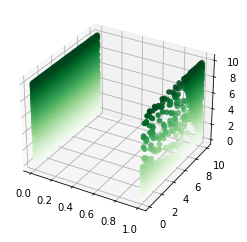

In [4]:
%matplotlib inline
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = x2
xdata = y
ydata = x1

# Data for a three-dimensional line
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

In [5]:
# packing explanatory variables in a pd.DataFrame
x = pd.DataFrame({'feature_1':x1, 'feature_2':x2})
y = pd.DataFrame({'y':y})

In [6]:
#obtaining default parameters by calling .fit() to XGBoost model instance
xgb_classifier1 = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators = 100,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide')
xgb_classifier1.fit(x,y)

C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [7]:
#extracting default parameters from benchmark model
default_params = {}
gparams = xgb_classifier1.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

### 11.1. Grid Search

We have two different ways to set up a grid-search approach on the hyperparameters. We present a manual and an automated procedure to perform grid-search on the hyperparameters.

##### 11.1.1. Manual Grid-search

In [8]:
base_search_dict = {'max_depth':[1,3,5],
                    'learning_rate':[0.01,0.1,1]}

In [9]:
# perform cartesian product over the elements of base_search_dict
from itertools import product
def my_product(inp):
    return (dict(zip(inp.keys(), values)) for values in product(*inp.values()))

In [10]:
# prepare the expanded dictionary to "save" the results
cp_grid_search = {}
for e,i in enumerate(my_product(base_search_dict)):
    name_model = f'model_{e}'
    cp_grid_search[name_model] = i

In [11]:
# fit 9 XGBClassifiers and retain the prediction in the dictionary created above
for i in cp_grid_search:
    xgb_gs = xgb.XGBClassifier(objective='binary:logistic',
                          n_estimators = 100,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          max_depth = cp_grid_search[i]['max_depth'],
                          learning_rate = cp_grid_search[i]['learning_rate'])
    xgb_gs.fit(x,y)
    cp_grid_search[i]['predict_class'] = xgb_gs.predict(x)

model_0 {'max_depth': 1, 'learning_rate': 0.01, 'predict_class': array([0, 0, 0, ..., 0, 0, 0])}
model_1 {'max_depth': 1, 'learning_rate': 0.1, 'predict_class': array([0, 0, 0, ..., 0, 0, 0])}
model_2 {'max_depth': 1, 'learning_rate': 1, 'predict_class': array([0, 1, 1, ..., 0, 0, 0])}
model_3 {'max_depth': 3, 'learning_rate': 0.01, 'predict_class': array([0, 0, 0, ..., 1, 1, 1])}
model_4 {'max_depth': 3, 'learning_rate': 0.1, 'predict_class': array([1, 1, 1, ..., 0, 0, 0])}
model_5 {'max_depth': 3, 'learning_rate': 1, 'predict_class': array([1, 1, 1, ..., 1, 0, 0])}
model_6 {'max_depth': 5, 'learning_rate': 0.01, 'predict_class': array([0, 0, 0, ..., 0, 0, 0])}
model_7 {'max_depth': 5, 'learning_rate': 0.1, 'predict_class': array([0, 1, 1, ..., 1, 0, 0])}
model_8 {'max_depth': 5, 'learning_rate': 1, 'predict_class': array([1, 1, 1, ..., 1, 0, 0])}


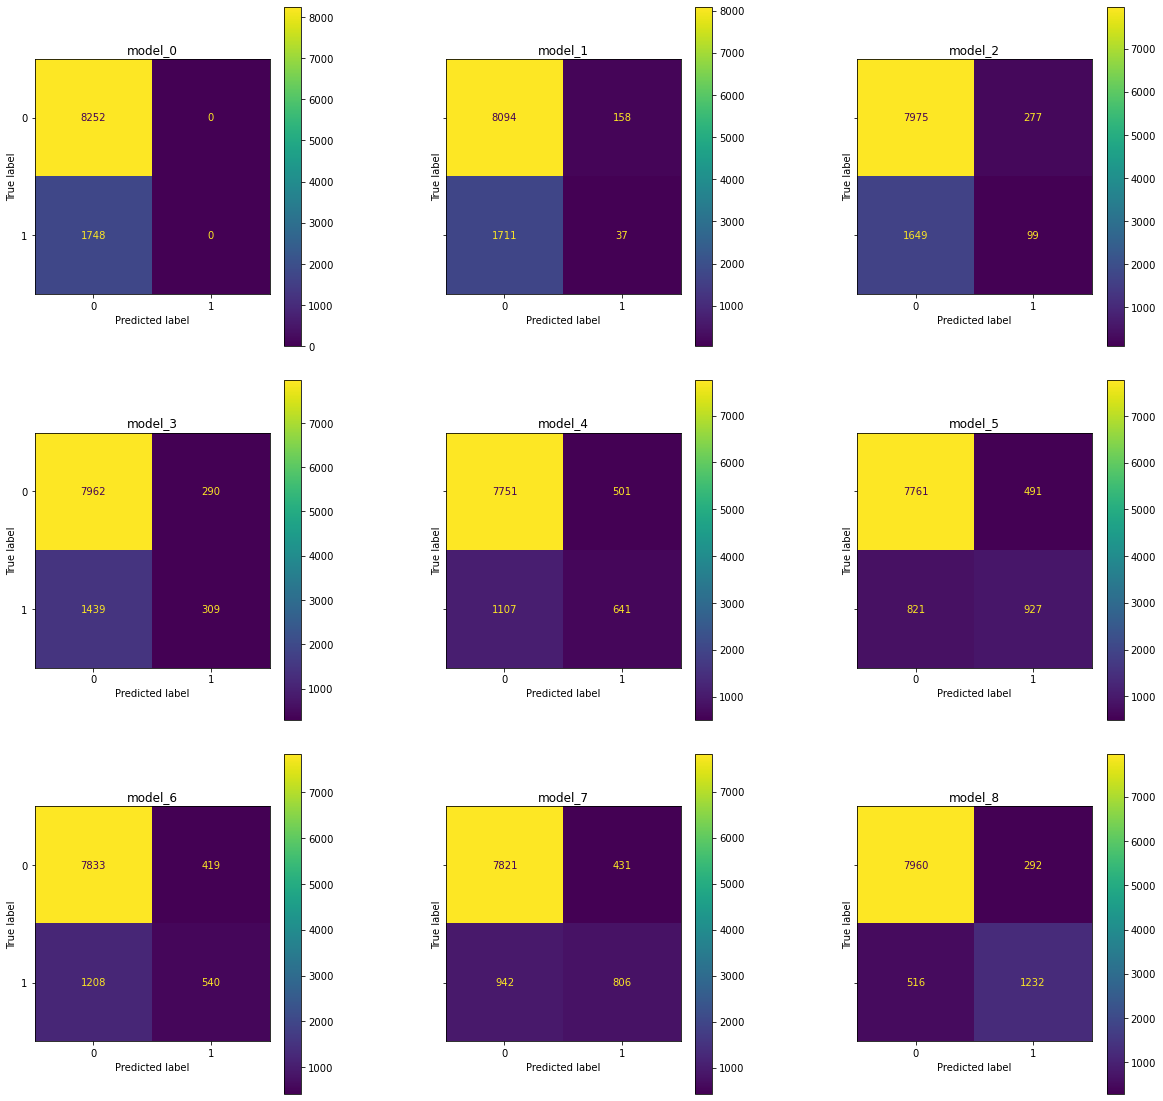

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline
f, axes = plt.subplots(3, 3, figsize=(20, 20), sharey='row')
axes = axes.ravel()

for i, (key, classifier) in enumerate(cp_grid_search.items()):
    print(key, classifier)
    axes[i].set_title(key)
    y_pred = classifier['predict_class']
    disp = ConfusionMatrixDisplay.from_predictions(y, y_pred, display_labels=['0', '1'], ax=axes[i], xticks_rotation=0)

plt.subplots_adjust(wspace=0.40, hspace=0.1)

##### 11.1.2. Automated Grid-search

We can exploit ```GridSearchCV``` from ```sklearn``` to automate the grid-search operation:
* a set of hyperparameters is required to be defined in a dictionary a priori
* all the combinations of the values defined in the dictionary are passed and evaluatied using Cross-Validation method
* we define a scoring rule to define which is the best parameter combination

The method ```sklearn.model_selection.GridSearchCV``` presents the following parameters:

* ```estimator```: pass the model instance for which you want to check the hyperparameters
* ```param_grid```: the dictionary object that holds the hyperparameters you want to try
* ```scoring```: evaluation metric that you want to use, you can simply pass a valid string/object of evaluation metric
* ```n_jobs```: number of processes you wish to run in parallel for this task if it -1 it will use all available processors. 
* ```cv```: number of cross-validation you have to try for each selected set of hyperparameters
* ```verbose```: you can set it to 1 to get the detailed print out while you fit the data to GridSearchCV
* ...

In [15]:
# define dictionary for gridsearch
search_dict = {'max_depth':[1,3,5],
               'learning_rate':[0.01,0.1,1]}

In [26]:
# execute cross_validation
xgb_classifier2 = GridSearchCV(estimator=xgb_classifier1,  
                               param_grid=search_dict,
                               scoring='roc_auc',
                               return_train_score=True, 
                               verbose=1, 
                               cv=3)
xgb_classifier2.fit(x, y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\u0149060\Anaconda3\envs\dev_env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='auc',
                                     gamma=0, gpu_id=-1,
                                     grow_policy='lossguide',
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=16,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scal

In [27]:
# extract optimal parameters after grid-search
optimal_params = {}
gparams = xgb_classifier2.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    optimal_params[key] = [gp]

In [28]:
# extract best parameters based on roc_auc scoring criteria
xgb_classifier2.best_params_ # according to manual grid search, this is model_4

{'learning_rate': 0.1, 'max_depth': 3}